In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('NYCTaxiFares.csv')

In [3]:
df = df.sample(frac = 1)
df.tail()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
29824,2010-04-21 22:41:05 UTC,12.9,1,-73.971808,40.794527,-73.961399,40.757543,3
46879,2010-04-15 11:35:40 UTC,6.5,0,-73.941883,40.798697,-73.960911,40.801166,1
10399,2010-04-24 14:21:51 UTC,6.9,0,-73.956320,40.771705,-73.975934,40.751854,2
50793,2010-04-24 23:38:49 UTC,8.5,0,-73.980550,40.740140,-73.993856,40.721144,1
93317,2010-04-19 12:38:51 UTC,6.5,0,-73.961207,40.777584,-73.969106,40.792624,1


In [4]:
df['fare_class'].unique()

array([0, 1])

In [5]:
def haversine_distance(df, lat1, long1, lat2, long2):
    
    r = 6371  # average radius of Earth in km
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [6]:
df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [7]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
109458,2010-04-15 18:36:44 UTC,5.70,0,-73.991918,40.758221,-74.000787,40.747377,1,1.418472
110888,2010-04-12 15:13:59 UTC,6.10,0,-73.884115,40.738228,-73.895635,40.750233,1,1.650398
82325,2010-04-16 17:13:19 UTC,18.90,1,-73.967838,40.792893,-73.967280,40.793363,1,0.070270
28981,2010-04-16 19:54:02 UTC,12.50,1,-73.981165,40.753109,-73.988302,40.720256,1,3.702247
62240,2010-04-16 13:40:00 UTC,49.57,1,-73.976178,40.779700,-73.782368,40.648787,1,21.879858


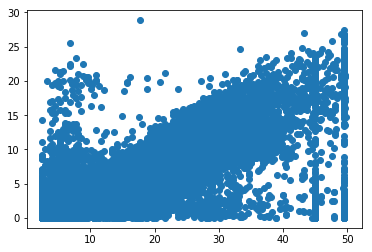

In [8]:
plt.scatter(df['fare_amount'], df['dist_km'])

In [9]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [10]:
my_time = df['pickup_datetime'][0]

In [11]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [12]:
df['Hour'] = df['EDTdate'].dt.hour

In [13]:
df['AMorPM'] = (df['Hour'] < 12).map({True : 'AM', False : 'PM'})
# df['AMorPM'] = np.where(df['Hour'] < 12, 'AM', 'PM')
# df['AMorPM2'] = df['Hour'].apply(lambda x: 'AM' if x < 12 else 'PM')
# df.drop('AMorPM2', axis = 1, inplace = True)

In [14]:
df['Weekday'] = df['EDTdate'].dt.strftime('%a')
# df['Weekday'] = df['EDTdate'].dt.dayofweek

In [15]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']
y_col = ['fare_amount']

In [16]:
for col in cat_cols:
    df[col] = df[col].astype('category')

In [17]:
hours = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
weekday = df['Weekday'].cat.codes.values
#df['Hour'].cat.categories

In [18]:
cats = np.stack([hours, ampm, weekday], axis = 1)
cats = torch.tensor(cats, dtype = torch.int64)
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
catz = cats[:2]

In [19]:
conts = np.stack([df[col] for col in cont_cols], axis = 1)
conts = torch.tensor(conts, dtype = torch.float)

In [20]:
y = torch.tensor(df[y_col].values, dtype = torch.float)

In [21]:
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])

In [22]:
embeddings = []

for i, e in enumerate(selfembeds):
    embeddings.append(e(catz[:, i]))

In [23]:
for e in embeddings:
    print(e)

tensor([[-0.0858, -0.4603, -0.2392, -0.1933, -1.3288,  0.4670,  0.7579, -1.3048,
          1.7103, -0.8346,  0.6708,  0.6821],
        [ 0.4254,  0.8677,  1.2941,  1.4482, -0.3255, -1.3831,  0.2686,  0.1928,
          0.0487,  0.2392, -0.6449,  0.1324]], grad_fn=<EmbeddingBackward>)
tensor([[1.1921],
        [0.5983]], grad_fn=<EmbeddingBackward>)
tensor([[-3.0453,  0.8579,  0.1950, -1.4311],
        [ 0.9151,  0.9821, -0.2597, -0.5838]], grad_fn=<EmbeddingBackward>)


In [24]:
class TabularModel(nn.Module):
    
    def __init__(self, emb_szs, n_cont, layers, out_sz, p = 0.5):
        
        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerslist = []
        n_emb = sum([nf for ni, nf in emb_szs])
        n_in = n_emb + n_cont
        
        for i in layers:
            layerslist.append(nn.Linear(n_in, i))
            layerslist.append(nn.ReLU(inplace = True))
            layerslist.append(nn.BatchNorm1d(i))
            layerslist.append(nn.Dropout(p))
            n_in = i
            
        layerslist.append(nn.Linear(layers[-1], out_sz))
        
        self.layers = nn.Sequential(*layerslist)
    
    
    def forward(self, x_cat, x_cont):
        
        embeddings = []
        
        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:, i]))
            
        x = torch.cat(embeddings, 1)
        x = self.drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        x = self.layers(x)
        
        return x
            

In [25]:
torch.manual_seed(33)

model = TabularModel(emb_szs, len(cont_cols), [200, 100], 1, 0.5)

In [26]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (drop): Dropout(p=0.5)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [28]:
batch_size = 60000
test_size = int(0.2*batch_size)

In [29]:
cat_train = cats[ : batch_size - test_size]
cat_test = cats[batch_size - test_size : batch_size]
cont_train = conts[ : batch_size - test_size]
cont_test = conts[batch_size - test_size : batch_size]
y_train = y[ : batch_size - test_size]
y_test = y[batch_size - test_size : batch_size]

In [30]:
epochs = 300
losses = []

for i in range(epochs):
    
    i += 1
    
    y_pred = model.forward(cat_train, cont_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)
    
    if i%25 == 1 : print(f'epoch : {i} \t loss : {loss}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch : 1 	 loss : 12.467013359069824
epoch : 26 	 loss : 11.588356971740723
epoch : 51 	 loss : 10.563981056213379
epoch : 76 	 loss : 9.604867935180664
epoch : 101 	 loss : 8.782537460327148
epoch : 126 	 loss : 7.869760513305664
epoch : 151 	 loss : 6.7764811515808105
epoch : 176 	 loss : 5.5644121170043945
epoch : 201 	 loss : 4.520942211151123
epoch : 226 	 loss : 3.8854475021362305
epoch : 251 	 loss : 3.70420241355896
epoch : 276 	 loss : 3.6308646202087402


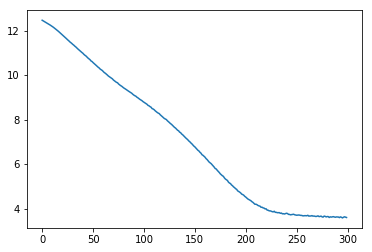

In [31]:
plt.plot(range(epochs), losses)

In [32]:
with torch.no_grad():
    y_eval = model(cat_test, cont_test)
    loss = torch.sqrt(criterion(y_eval, y_test))

In [33]:
loss

tensor(3.4857)

In [34]:
with torch.no_grad():
    for i in range(10):
        print(f' Predicted Value : {y_eval[i]} Actual value : {y_test[i]} ')

 Predicted Value : tensor([5.1223]) Actual value : tensor([4.5000]) 
 Predicted Value : tensor([10.3776]) Actual value : tensor([13.3000]) 
 Predicted Value : tensor([5.3217]) Actual value : tensor([4.1000]) 
 Predicted Value : tensor([4.9386]) Actual value : tensor([6.5000]) 
 Predicted Value : tensor([3.7614]) Actual value : tensor([3.3000]) 
 Predicted Value : tensor([6.6376]) Actual value : tensor([8.9000]) 
 Predicted Value : tensor([49.4731]) Actual value : tensor([49.5700]) 
 Predicted Value : tensor([7.0475]) Actual value : tensor([8.5000]) 
 Predicted Value : tensor([3.3158]) Actual value : tensor([14.5000]) 
 Predicted Value : tensor([9.0858]) Actual value : tensor([10.5000]) 


In [35]:
torch.save(model.state_dict(), 'taxi_fare_predictor.pt')